In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from sklearn import datasets
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA, COBYLA
from qiskit.circuit.library import TwoLocal, ZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

In [5]:
SEED = 294
qasm_sim = AerSimulator()

# Dataset

In [6]:
data = datasets.fetch_california_housing()
california_df = pd.DataFrame(data=data.data, columns=data.feature_names)
california_df['target'] = data.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


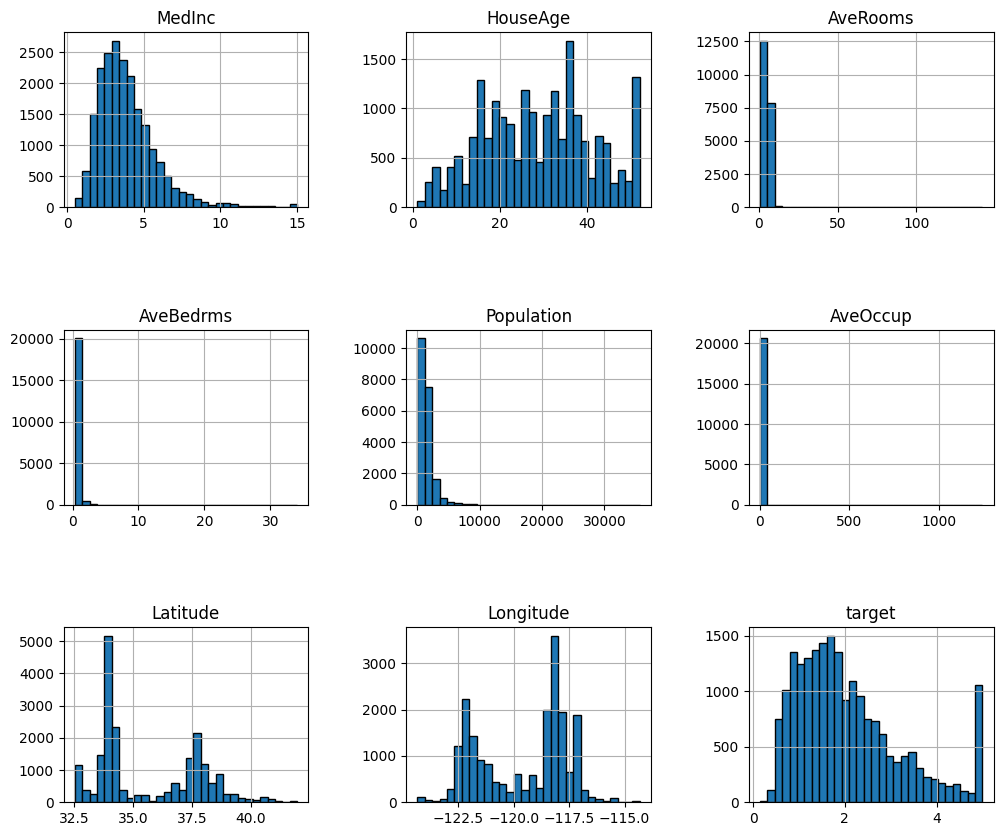

In [7]:
california_df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [8]:
mean_value = california_df['target'].mean()
mean_value

2.068558169089147

In [9]:
# Split the dataset into two groups based on the output variable
mid_range_samples = california_df[california_df['target'] < mean_value].sample(n=300, random_state=SEED)
luxury_samples = california_df[california_df['target'] > mean_value].sample(n=300, random_state=SEED)

In [10]:
training_data = pd.concat([mid_range_samples, luxury_samples])
X = training_data.drop('target', axis=1) 
Y = training_data['target'].apply(lambda x: 0 if x < mean_value else 1)

In [11]:
x, y = X.to_numpy(), Y.to_numpy()
num_features = 8
x.shape

(600, 8)

In [12]:
# Normalization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
x = std_scaler.fit_transform(x)

In [13]:
test_ratio = 0.2
x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size=test_ratio, random_state=SEED)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 480
Test set size:  120


In [14]:
x_train[0]

array([ 2.00456045, -0.99719831,  1.29795886, -0.46455451, -0.02187002,
       -0.05838653, -0.64951938,  0.32960961])

# Data embedding circuits

c:\Users\lebam\.venv\qml-winterschool\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


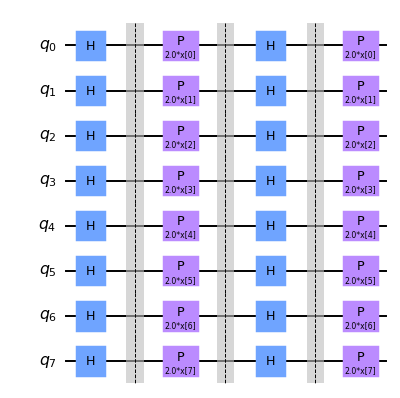

In [15]:
fmap_z = ZFeatureMap(num_features, 2, insert_barriers=True) 
input_params = fmap_z.parameters
fmap_z.decompose().draw('mpl', scale=0.7)

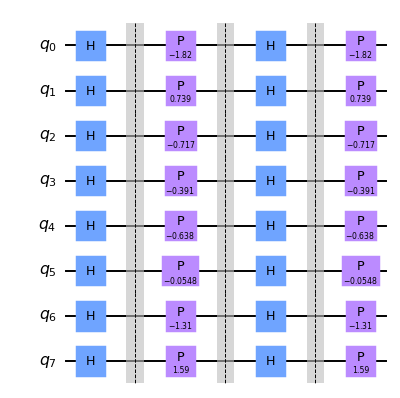

In [16]:
fmap_z.assign_parameters({k:v for (k,v) in zip(fmap_z.parameters, x[0])}).decompose().draw('mpl', scale=0.7)

# Anstaz

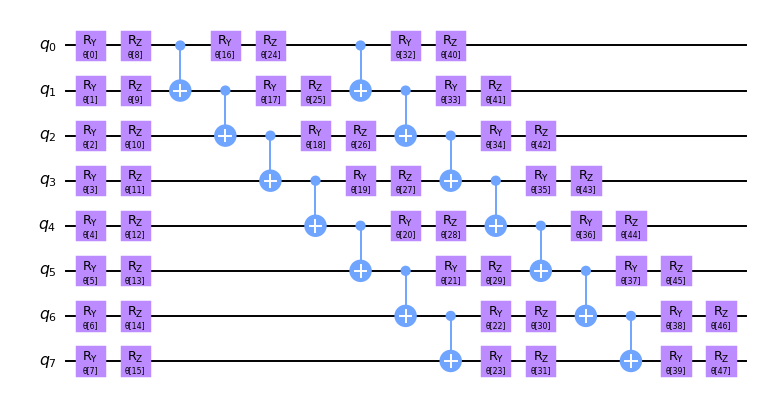

In [17]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

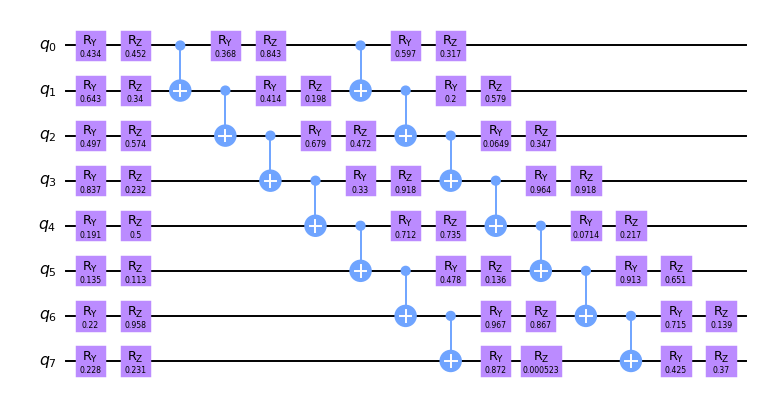

In [18]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

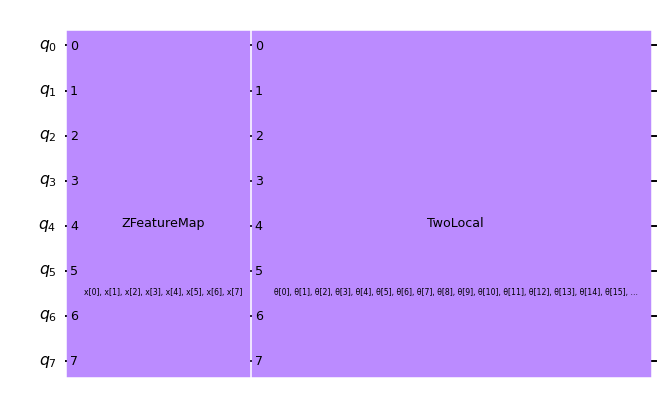

In [19]:
var_circuit = fmap_z.compose(ansatz_tl)
var_circuit.draw('mpl', scale=0.7)

# Primitives

For info, see https://docs.quantum.ibm.com/run/primitives

In [20]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

# Quantum Neural Network

## SamplerQNN

In [21]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [22]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [23]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

### Forward pass

In [25]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 600 samples: (600, 2)
Output of the forward pass for first sample: [0.12890625 0.87109375]


### Backward pass

In [26]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")


Output shape for 600 samples: (600, 2, 48)
Output of the backward pass for first sample: [[-0.30419922 -0.01269531 -0.00244141  0.00048828  0.00634766  0.00097656
   0.00537109 -0.00097656  0.01171875  0.00830078  0.00244141 -0.00927734
   0.00146484  0.00732422  0.00292969 -0.00634766 -0.24169922 -0.01220703
  -0.00341797  0.00683594 -0.00244141  0.01123047  0.00732422 -0.00927734
  -0.00292969  0.00146484  0.00439453  0.00244141  0.          0.00244141
   0.00195312 -0.00439453 -0.06298828  0.01757812 -0.00292969 -0.00439453
   0.0078125  -0.00292969 -0.00732422 -0.01123047  0.00195312 -0.00048828
   0.00537109 -0.00195312  0.00048828  0.02001953  0.          0.00976562]
 [ 0.30419922  0.01269531  0.00244141 -0.00048828 -0.00634766 -0.00097656
  -0.00537109  0.00097656 -0.01171875 -0.00830078 -0.00244141  0.00927734
  -0.00146484 -0.00732422 -0.00292969  0.00634766  0.24169922  0.01220703
   0.00341797 -0.00683594  0.00244141 -0.01123047 -0.00732422  0.00927734
   0.00292969 -0.00146

## EstimatorQNN

In [24]:
obs_parity = Pauli('Z' * num_features)
obs_one_qubit = Pauli('I' * (num_features - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

Parity observable: ZZZZZZZZ
First qubit observable: IIIIIIIZ


In [25]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

### Forward pass

In [91]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 200 samples: (200, 1)
Output of the forward pass for first sample: [-0.06445312]


### Backward pass

In [92]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 200 samples: (200, 1, 48)
Output of the backward pass for first sample: [[-0.31054688  0.04101562  0.00195312  0.0078125   0.          0.
   0.03320312 -0.00097656  0.29101562  0.21484375 -0.05371094  0.00195312
   0.02734375  0.03027344 -0.00488281  0.00488281  0.35839844  0.21289062
   0.01171875 -0.00585938 -0.01171875  0.02539062  0.01171875 -0.02734375
   0.14453125 -0.02148438  0.         -0.00390625  0.02441406  0.
  -0.00585938  0.02636719  0.37695312  0.00292969  0.04882812 -0.00390625
  -0.02832031  0.04003906 -0.00195312 -0.03808594  0.         -0.01269531
   0.05664062  0.01269531  0.02636719  0.00585938 -0.01757812  0.00878906]]


# Train a Neural Network Classifier

In [ ]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[11]} converted to {y_train_1h[11]}")
print(f"Label {y_train[22]} converted to {y_train_1h[22]}")

Label 1 converted to [0 1]
Label 0 converted to [1 0]


In [ ]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [48]:
max_itr = 100
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(x_train, y_train_1h)

Text(0.5, 1.0, 'Training loss')

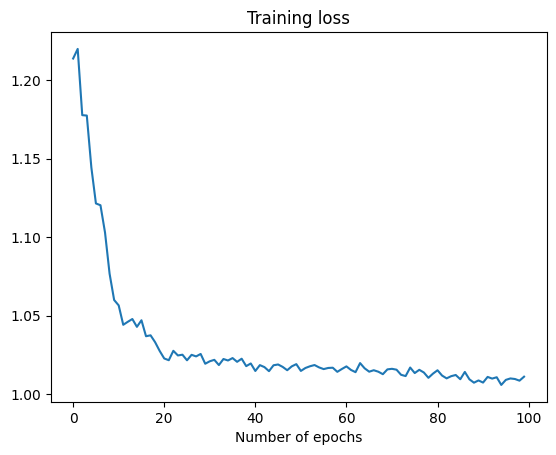

In [ ]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5270833333333333
Score on the test set 0.5916666666666667


In [ ]:
y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)

In [ ]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [ ]:
x_all = np.concatenate((x_train, x_test))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

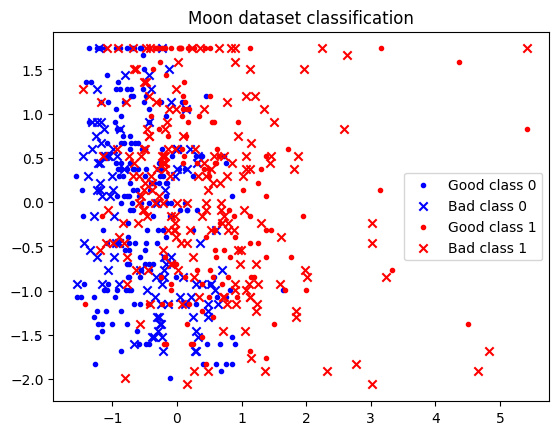

In [ ]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Moon dataset classification")
plt.legend()

### Other Experiment

In [42]:
max_itr = 300
cobyla_opt = COBYLA(maxiter=max_itr)
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=cobyla_opt,
                              initial_point=initial_point)

vqc = vqc.fit(x_train, y_train_1h)

In [43]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5270833333333333
Score on the test set 0.5083333333333333


In [44]:
y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)

In [45]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [46]:
x_all = np.concatenate((x_train, x_test))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

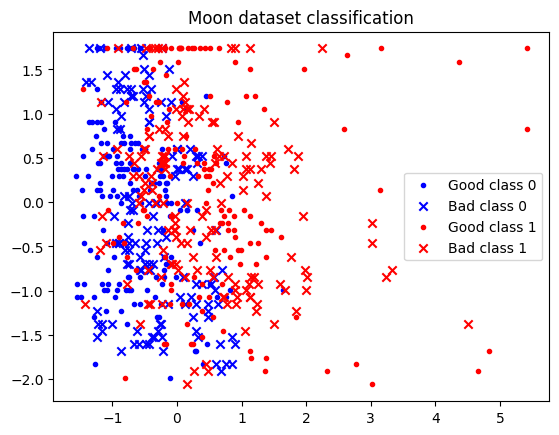

In [47]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Moon dataset classification")
plt.legend()